# Check data augmentation

In [11]:
import os 
import sys
import numpy as np

In [2]:
sys.path.append("../submissions/keras_cnns_pretrained")
sys.path.append("../")

In [3]:
from image_preprocessor import transform, transform_test
from problem import get_cv, get_train_data

In [4]:
from rampwf.workflows.image_classifier import BatchGeneratorBuilder

In [5]:
n_classes = 403
batch_size = 16

In [6]:
def normalize(in_img, q_min=0.5, q_max=99.5, return_mins_maxs=False):
    """
    Normalize image in [0.0, 1.0]
    mins is array of minima
    maxs is array of differences between maxima and minima
    """
    init_shape = in_img.shape
    if len(init_shape) == 2:
        in_img = np.expand_dims(in_img, axis=2)
    w, h, d = in_img.shape
    img = in_img.copy()
    img = np.reshape(img, [w * h, d]).astype(np.float64)
    mins = np.percentile(img, q_min, axis=0)
    maxs = np.percentile(img, q_max, axis=0) - mins
    maxs[(maxs < 0.0001) & (maxs > -0.0001)] = 0.0001
    img = (img - mins[None, :]) / maxs[None, :]
    img = img.clip(0.0, 1.0)
    img = np.reshape(img, [w, h, d])
    if init_shape != img.shape:
        img = img.reshape(init_shape)
    if return_mins_maxs:
        return img, mins, maxs
    return img


def scale_percentile(matrix, q_min=0.5, q_max=99.5):
    is_gray = False
    if len(matrix.shape) == 2:
        is_gray = True
        matrix = matrix.reshape(matrix.shape + (1,))
    matrix = (255 * normalize(matrix, q_min, q_max)).astype(np.uint8)
    if is_gray:
        matrix = matrix.reshape(matrix.shape[:2])
    return matrix

In [7]:
folder_X_train, y_train = get_train_data(path="..")
cv = list(get_cv(folder_X_train, y_train))

for fold_i, (train_is, valid_is) in enumerate(cv):

    folder, X_train = folder_X_train

    gen = BatchGeneratorBuilder(X_array=X_train[train_is], y_array=y_train[train_is], 
                                transform_img=transform, transform_test_img=transform_test, 
                                folder=folder, 
                                chunk_size=batch_size*5, 
                                n_classes=n_classes, n_jobs=1)
    break

In [8]:
import matplotlib.pylab as plt
%matplotlib inline

In [9]:
gen_train, gen_valid, nb_train, nb_valid = gen.get_train_valid_generators(batch_size=batch_size, valid_ratio=0.3)

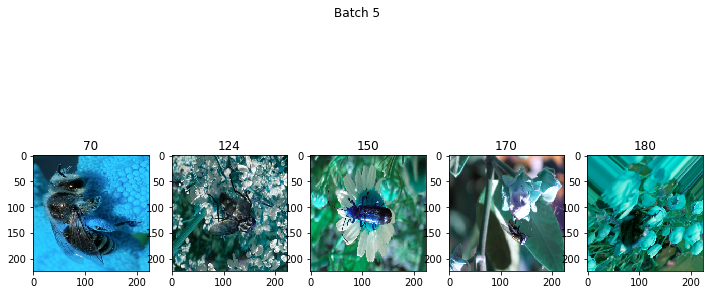

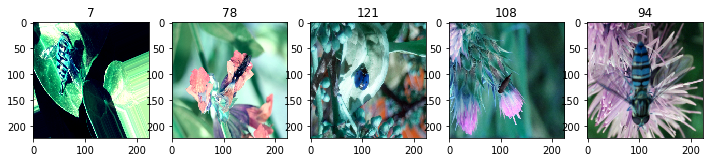

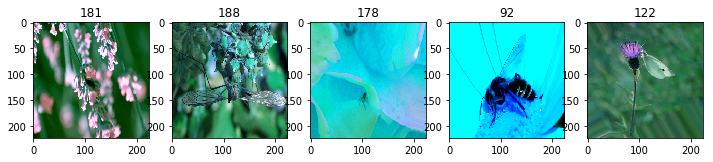

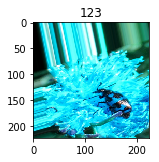

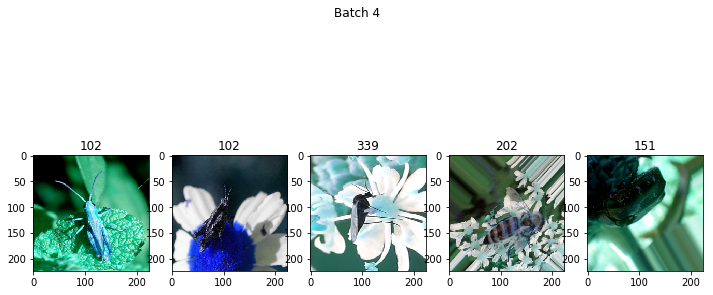

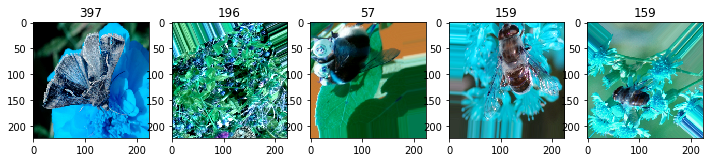

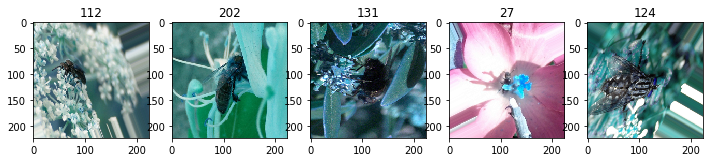

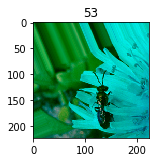

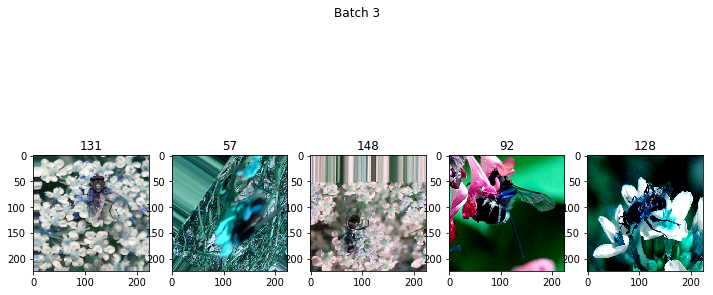

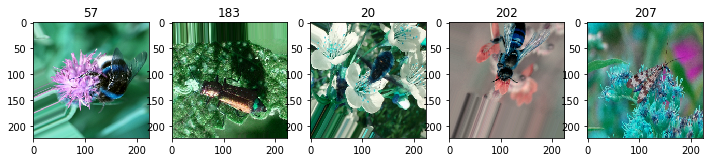

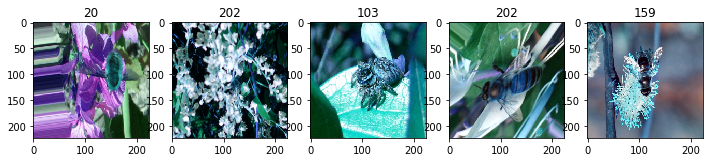

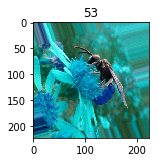

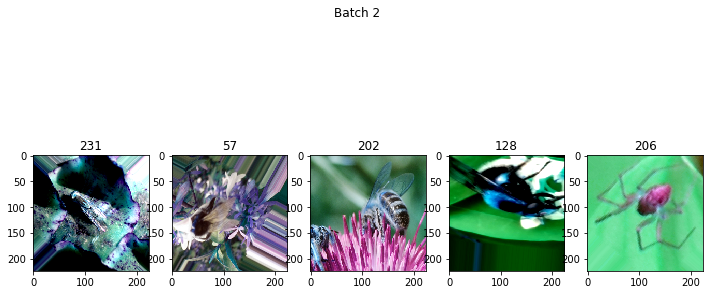

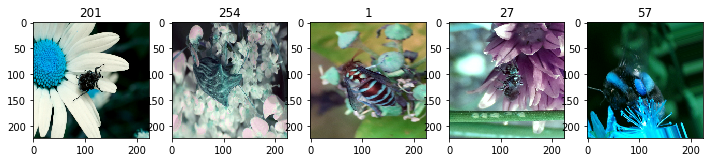

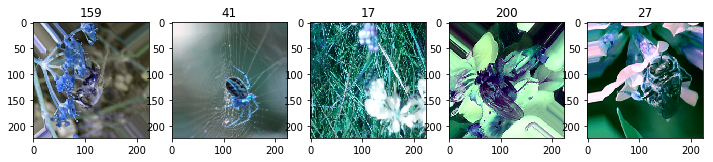

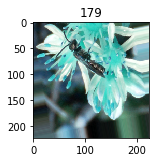

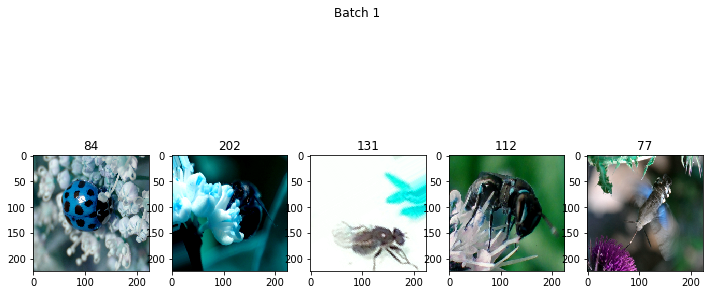

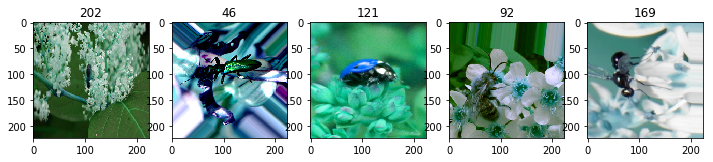

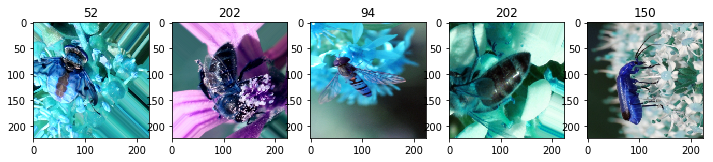

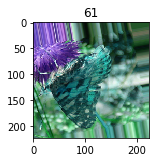

In [15]:
max_counter = 5
n = 5
for batch_images, batch_labels in gen_train:
    
    index = 0    
    plt.figure(figsize=(12, 6))
    plt.suptitle('Batch %i' % max_counter)
    for img, y in zip(batch_images, batch_labels):
        if index > 0 and index % n == 0:
            plt.figure(figsize=(12, 6))
        plt.subplot(1, n, (index % n) + 1)
        class_index = np.where(y > 0)[0][0]
        plt.title("%i" % class_index)
        plt.imshow(scale_percentile(img, 0.0, 100.0))  
        index += 1
    
    max_counter -= 1
    if max_counter == 0:
        break

In [16]:
import os 
import numpy as np
import pandas as pd

INPUT_PATH = '../data'
TRAIN_TEST_DATA = os.path.join(INPUT_PATH, 'imgs')
TRAIN_CSV_PATH = os.path.join(INPUT_PATH, 'train.csv')
TEST_CSV_PATH = os.path.join(INPUT_PATH, 'test.csv')

TRAIN_CSV_DF = pd.read_csv(TRAIN_CSV_PATH)
TEST_CSV_DF = pd.read_csv(TEST_CSV_PATH)

train_ids = TRAIN_CSV_DF['id'].values
train_classes = TRAIN_CSV_DF['class'].values

In [17]:
import cv2

def get_filename(image_id, image_type):
    """
    Method to get image file path from its id and type
    """
    check_dir = False
    ext = ''
    prefix = '' 
    if "Train" in image_type: 
        data_path = TRAIN_TEST_DATA
    elif "Test" in image_type:
        data_path = TRAIN_TEST_DATA
    else:
        raise Exception("Image type '%s' is not recognized" % image_type)

    if check_dir and not os.path.exists(data_path):
        os.makedirs(data_path)
    if len(ext) > 0:
        return os.path.join(data_path, "{}{}.{}".format(prefix, image_id, ext))
    return os.path.join(data_path, "{}{}".format(prefix, image_id, ext))    
    

_gb = TRAIN_CSV_DF.groupby('id')
_id_class_gb = _gb['class']    
    
def get_label(image_id, image_type):
    return _id_class_gb.get_group(image_id)

    
def get_image_data(image_id, image_type):
    fname = get_filename(image_id, image_type)
    img = cv2.imread(fname)
    assert img is not None, "Failed to read image : %s, %s" % (image_id, image_type)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
    

In [18]:
img = get_image_data(train_ids[0], "Train")

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(scale_percentile(transform(img)[:,:,::-1], 0.0, 100.0))